In [1]:
import sys
import os
import numpy as np 
import pandas as pd
from deap import algorithms, base, creator, tools
from tqdm import tqdm
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt 


def main():
    """ 
    Main execution loop.
    Runs the DEAP simple algorithm.
    """

    # set the parameters for evolution
    n_pop = 100
    n_gen = 100
    crossover_probability = 0.5
    mutation_probability = 0.5

    n_runs = 10

    # generate the initial population
    pop = toolbox.population(n=n_pop)

    # save the fittest member
    hof = tools.HallOfFame(1)

    # specify some statistics you want to trach during evolution
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run the eaSimple algorithm
    pop, log = algorithms.eaSimple(
        population=pop, 
        toolbox=toolbox, 
        stats=stats, 
        cxpb=crossover_probability, 
        mutpb=mutation_probability, 
        ngen=n_gen, 
        # halloffame=hof, 
        verbose=True
    )

    print(np.array(pop).shape)

    # save the fittest member
    # fittest_member = np.array(hof[0])

    # https://stackoverflow.com/questions/42904904/saving-deap-results-into-pandas-dataframe
    data = [[j for j in item.values()] for item in log]

    # print(data)

    return np.array(pop)


def evaluate(pos):
    """ 
    Evaluate the fitness of an individual.
    """
    pos = pos[0]
    for p in pos:
        if np.sqrt(p[0] ** 2 + p[1] ** 2) > 1:
            return [1000]
    dist = cdist(pos, pos)
    li = np.tril_indices(len(pos), k=-1)
    pair_dist = dist[li]
    total_energy = (1 / pair_dist).sum()
    return [total_energy]

def init_pos(n):
    # initialize particles
    r = np.random.rand(n)
    theta = np.random.rand(n) * 2 * np.pi
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    pos = np.stack((x, y), axis=1)
    return pos

if __name__ == '__main__':

    # STEP 2: give instructions on how to generate the population
    n = 3
    # DEAP's version of a configuration file
    toolbox = base.Toolbox()

    # set fitness to be maximized
    creator.create("FitnessMin", base.Fitness, weights=[-1])

    # individuals will be in the form of a list 
    # their fitness will be judged based on 'FitnessMax'
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # the list that makes up an individual will be filled with an attribute
    # an attribute here is a random sample from the uniform distribution
    toolbox.register('attribute', init_pos, n=n)

    # an indivual will be make by repeatingly adding attributes, n_vars times
    toolbox.register('individual', tools.initRepeat, 
        creator.Individual, toolbox.attribute, 1)

    # the population will be another list
    # this one made by repeatingly adding individuals
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)


    # STEP 3: give instructions on how to evolve the population
    # there are multiple choices for every function
    # more found at: https://deap.readthedocs.io/en/master/api/tools.html

    # function to evaluate the fitness of a member
    # playing the game in our case
    toolbox.register('evaluate', evaluate)

    # function for crossover
    alpha = 1 # no idea what this does
    toolbox.register('mate', tools.cxBlend, alpha=alpha)

    # function for child mutation
    mean = 0
    stdev = 0.05
    individual_mutation_probability = 0.2
    toolbox.register('mutate', tools.mutGaussian, mu=mean, 
        sigma=stdev, indpb=individual_mutation_probability)

    # function for parent selection
    toolbox.register('select', tools.selTournament, tournsize=3)

    pop = main()


gen	nevals	avg    	min    	max    
0  	100   	6.00367	2.22926	30.7787
1  	81    	312.701	2.47892	1000   
2  	71    	272.526	1.93997	1000   
3  	78    	242.602	1.86753	1000   
4  	76    	182.362	1.86753	1000   
5  	64    	201.969	1.86753	1000   
6  	85    	181.765	1.80585	1000   
7  	83    	211.709	1.80585	1000   
8  	71    	131.684	1.80519	1000   
9  	73    	161.582	1.80519	1000   
10 	71    	151.57 	1.8041 	1000   
11 	72    	121.607	1.8041 	1000   
12 	73    	171.504	1.79675	1000   
13 	71    	251.355	1.79675	1000   
14 	81    	201.444	1.7958 	1000   
15 	78    	161.516	1.79504	1000   
16 	74    	141.55 	1.79349	1000   
17 	82    	211.422	1.79235	1000   
18 	76    	281.294	1.78805	1000   
19 	77    	311.239	1.78533	1000   
20 	82    	281.291	1.7771 	1000   
21 	78    	161.504	1.77083	1000   
22 	76    	131.555	1.76778	1000   
23 	71    	81.641 	1.7658 	1000   
24 	74    	171.477	1.76503	1000   
25 	77    	171.474	1.76433	1000   
26 	67    	131.542	1.76179	1000   
27 	73    	121.557	1

In [2]:
def rotation(pos, theta_rotation):
    # get polar coordinates
    x = pos[:, 0]
    y = pos[:, 1]
    r = np.sqrt(x ** 2 + y ** 2)
    theta = np.arctan2(y, x)

    # add an angle
    theta = theta + theta_rotation

    # back to cartesian
    x = np.cos(theta) * r
    y = np.sin(theta) * r
    pos = np.stack((x, y), axis=1)

    return pos

def difference_score(theta_rotation, standard_pos, pos):
    # rotate
    pos = rotation(pos, theta_rotation)

    # return distance score
    return cdist(standard_pos, pos).min(axis=1).sum()

def get_minimized_config(standard_pos, pos, precision=1000):

    radians = np.linspace(0, 2 * np.pi, precision)
    scores = [difference_score(r, standard_pos, pos) for r in radians]
    best_radian = radians[np.argmin(scores)]
    return rotation(pos, best_radian)  

def total_energy(pos):
    dist = cdist(pos, pos)
    li = np.tril_indices(len(pos), k=-1)
    pair_dist = dist[li]
    total_energy = (1 / pair_dist).sum()
    return total_energy  

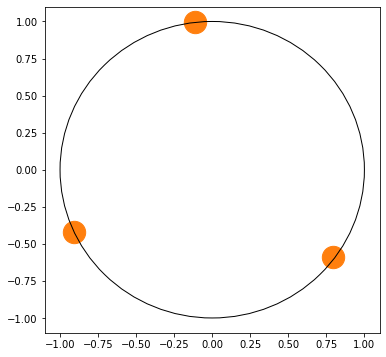

In [3]:
import matplotlib.pyplot as plt 

quality = []
for r in pop:
    # print(np.sqrt(r[0][:, 0] ** 2 + r[0][:, 1] ** 2))
    if (np.sqrt(r[0][:, 0] ** 2 + r[0][:, 1] ** 2) > 1).any():
        quality.append(1000)
        continue
    q = total_energy(r[0])
    quality.append(q)

standard_pos = pop[:, 0][np.argmin(quality)]

plt.figure(figsize=(6, 6))
plt.scatter(standard_pos[:, 0], standard_pos[:, 1], s=500, zorder=-100, color='tab:orange')
circle = plt.Circle((0, 0), 1, fill=False)
plt.gca().add_patch(circle)
plt.show()

In [4]:
# import matplotlib.pyplot as plt 

# standard_pos = pop[0][0]
# plt.figure(figsize=(6, 6))
# for p in pop:
#     plot_p = get_minimized_config(standard_pos, p[0])
#     plt.scatter(plot_p[1:, 0], plot_p[1:, 1], color='tab:blue', edgecolors='darkslategray')
# plt.scatter(standard_pos[:, 0], standard_pos[:, 1], s=500, zorder=-100, color='tab:orange')
# circle = plt.Circle((0, 0), 1, fill=False)
# plt.gca().add_patch(circle)
# plt.show()